In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn import *


In [13]:
df = pd.read_csv('../Get_Data_BTC/BTC_Daily_ohlc.csv')
start_date = "2022-12-26"
mask = (df["date"] > start_date) 
df = df.loc[mask]
df['SMA_5_days'] = df['close'].rolling(window=5).mean()
df['SMA_3_days'] = df['close'].rolling(window=3).mean()

start_date = "2023-01-01"
mask = (df["date"] > start_date) 
df = df.loc[mask]
print(df.head())



                     date          open          high           low  \
1962  2023-01-01 09:00:00  16541.712741  16627.970811  16498.995357   
1963  2023-01-02 09:00:00  16617.151524  16799.083296  16548.728098   
1964  2023-01-03 09:00:00  16672.738771  16778.293046  16605.277585   
1965  2023-01-04 09:00:00  16675.625716  16991.797881  16652.653952   
1966  2023-01-05 09:00:00  16850.336901  16879.759365  16753.013749   

             close    SMA_5_days    SMA_3_days  
1962  16616.741487  16589.426172  16588.828837  
1963  16672.871107  16614.555022  16610.645740  
1964  16675.135321  16622.898587  16654.915971  
1965  16850.347537  16671.484015  16732.784655  
1966  16831.809783  16729.381047  16785.764214  


In [14]:
def candleplot(df,  x_min = 0, x_max = len(df) , filename = "plot_BTC"):
    ## Figure params
    plt.figure(dpi = 200)
    plt.ylabel('price (dollars)')
    plt.title('Bitcoin')
    plt.xlabel('days')
    plt.grid(True)

    ## Import ohlc 
    opens = df['open'].values[x_min:x_max]
    truth = df['close'].values[x_min:x_max]
    highs = df['high'].values[x_min:x_max]
    lows = df['low'].values[x_min:x_max]
    sma = df['SMA_3_days'].values[x_min:x_max]

    ## Draw candles
    height = truth - opens
    bottom = np.where(height > 0, opens, truth + abs(height))
    color = np.where(height > 0, 'g', 'r')
    plt.bar(range(x_min,len(truth) + x_min), height, bottom=bottom, color=color, align='center')
    plt.vlines(range(x_min, x_min + len(highs)), ymin=lows, ymax=highs, color=color, linewidth=1)
    plt.plot(range(x_min,len(truth) + x_min), sma, color = "purple")

    plt.savefig(f'./plot/{filename}')


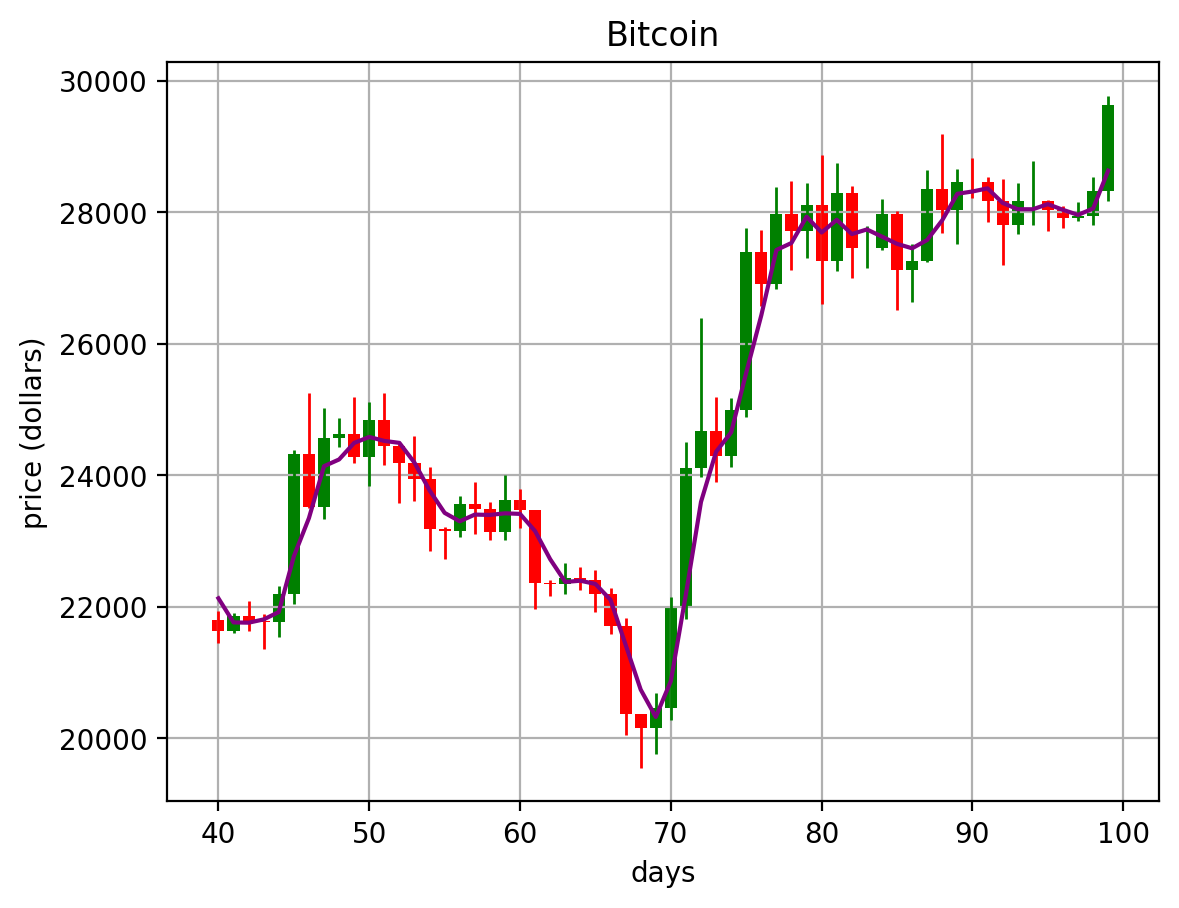

In [15]:
candleplot(df,  x_min = 40, x_max = 100 , filename = "test")

In [18]:
def avg_plot(df,  x_min = 0, x_max = len(df) , filename = "plot_BTC"):
    ## Figure params
    plt.figure(dpi = 200)
    plt.ylabel('price (dollars)')
    plt.title('Bitcoin')
    plt.xlabel('days')
    plt.grid(True)

    ## Import ohlc 
    highs_sma = df['high_sma'].values[x_min:x_max]
    lows_sma = df['low_sma'].values[x_min:x_max]
    sma = df['SMA_3_days'].values[x_min:x_max]

    plt.scatter(range(x_min, x_max),highs_sma, color = "brown")
    plt.scatter(range(x_min, x_max),lows_sma, color = "blue")

    plt.plot(range(x_min, x_max), sma, color = "purple")

    plt.savefig(f'./plot/{filename}')


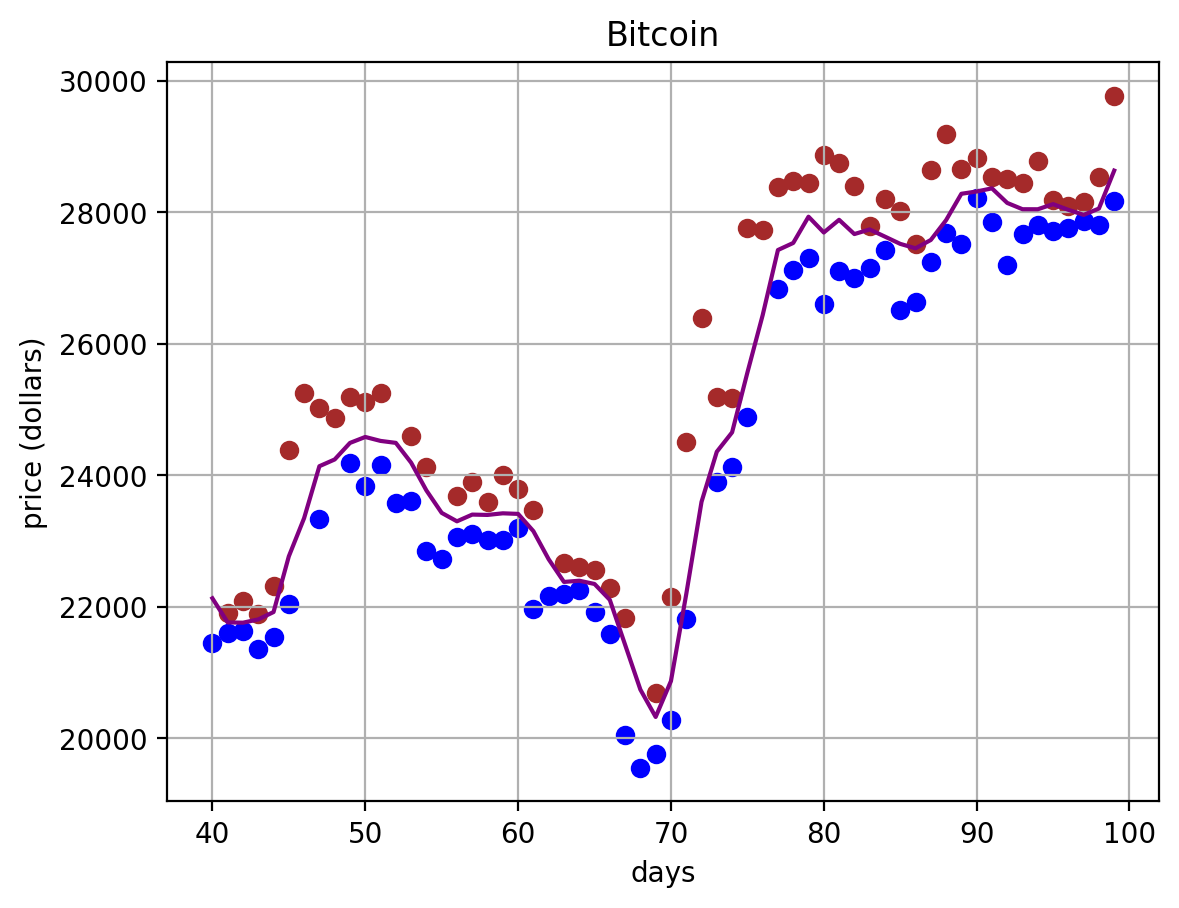

In [19]:
df_copy = df.copy()

mask_compare_high = df_copy["high"] > df_copy["SMA_3_days"]
mask_compare_low = df_copy["low"] < df_copy["SMA_3_days"]

df_copy['high_sma'] = np.where(mask_compare_high, df_copy['high'], np.nan)
df_copy['low_sma'] = np.where(mask_compare_low, df_copy['low'], np.nan)

avg_plot(df_copy,  x_min = 40, x_max = 100 , filename = "test")


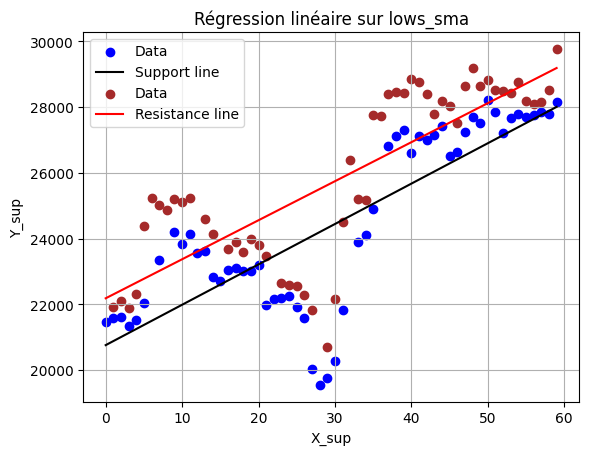

Support train score: 0.6399013811971419
Resistance train score: 0.375812445857609


In [27]:
x_min = 40
x_max = 100
X_sup = []
Y_sup = []
X_res = []
Y_res = []

highs_sma = df_copy['high_sma'].values[x_min:x_max]
lows_sma = df_copy['low_sma'].values[x_min:x_max]
sma = df['SMA_3_days'].values[x_min:x_max]

for i, value in enumerate(lows_sma):
    if not pd.isna(lows_sma[i]):
        X_sup.append(i)
        Y_sup.append(value)

for i, value in enumerate(highs_sma):
    if not pd.isna(highs_sma[i]):
        X_res.append(i)
        Y_res.append(value)

ols_reg_sup = linear_model.LinearRegression().fit(np.array(X_sup).reshape(-1, 1), Y_sup)
# Prédire les valeurs pour tracer la ligne de régression
x_values = np.array(range(len(lows_sma))).reshape(-1, 1)
predicted_values = ols_reg_sup.predict(x_values)

# Tracer les données et la ligne de régression
plt.scatter(X_sup, Y_sup, color='blue', label='Data')  # Points de données
plt.plot(x_values, predicted_values, color='black', label='Support line')  # Ligne de régression linéaire

ols_reg_res = linear_model.LinearRegression().fit(np.array(X_res).reshape(-1, 1), Y_res)
# Prédire les valeurs pour tracer la ligne de régression
x_values = np.array(range(len(highs_sma))).reshape(-1, 1)
predicted_values = ols_reg_res.predict(x_values)

# Tracer les données et la ligne de régression
plt.scatter(X_res, Y_res, color='brown', label='Data')  # Points de données
plt.plot(x_values, predicted_values, color='red', label='Resistance line')  # Ligne de régression linéaire



# Ajouter des légendes, des titres, etc.
plt.xlabel('X_sup')
plt.ylabel('Y_sup')
plt.title('Régression linéaire sur lows_sma')
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

# Calcul des scores de régression
train_score = ols_reg_sup.score(np.array(X_sup).reshape(-1, 1), Y_sup)
print("Support train score:", train_score)

train_score = ols_reg_sup.score(np.array(X_res).reshape(-1, 1), Y_res)
print("Resistance train score:", train_score)